*Арешин Станислав Олегович М8О-404Б-17*

**Лабораторная работа №8 по курсу Численные методы**

*Москва 2020*

# Постановка задачи

**Вариант 1**

*Уравнение:*

$$\frac{\partial u}{\partial t} = a\frac{\partial^2 u}{\partial x^2} + a\frac{\partial^2 u}{\partial y^2}$$

$$u(0,y,t) = cos(\mu_2y)exp(-(\mu_1^2 + \mu_2^2)at)$$

$$u(\pi,y,t)= (-1)^{\mu_1}cos(\mu_2y)exp(-(\mu_1^2 + \mu_2^2)at)$$

$$u(x,0,t)= cos(\mu_1x)exp(-(\mu_1^2 + \mu_2^2)at)$$

$$u(x,\pi,t)=(-1)^{\mu_2}cos(\mu_1x)exp(-(\mu_1^2 + \mu_2^2)at)$$

$$u(x,y,0)=cos(\mu_1x)cos(\mu_2y)$$

*Аналитическое решение:*

$$U(x,y,t) = cos(\mu_1x)cos(\mu_2y)exp(-(\mu_1^2 + \mu_2^2)at)$$

1) $\mu_1 = 1, \mu_2 = 1$

2) $\mu_1 = 2, \mu_2 = 1$

3) $\mu_1 = 1, \mu_2 = 2$

Используя схемы переменных направлений и дробных шагов, решить двумерную начально-краевую задачу для дифференциального уравнения параболического типа. В различные моменты времени вычислить погрешность численного решения путем сравнения результатов с приведенным в задании аналитическим решением $U(x,y,t)$ . Исследовать зависимость погрешности от сеточных параметров $\tau, h_x, h_y$ .

In [1]:
import numpy as np


In [2]:
a = 1

def U(x, y, t, m1, m2):
    return np.cos(m1 * x) * np.cos(m2 * y) * np.exp(-(m1 ** 2 + m2 ** 2) * a * t)

def u0jk(m1, m2, y, t, j, k):
    return np.cos(m2 * y[j]) * np.exp(-(m1 ** 2 + m2 ** 2) * a * t[k])
                                  
def uNxjk(m1, m2, y, t, j, k):
    return (-1) ** m1 * np.cos(m2 * y[j]) * np.exp(-(m1 ** 2 + m2 ** 2) * a * t[k])
                                  
def ui0k(m1, m2, x, t, i, k):
    return np.cos(m1 * x[i]) * np.exp(-(m1 ** 2 + m2 ** 2) * a * t[k])

def uiNyk(m1, m2, x, t, i, k):
    return (-1) ** m2 * np.cos(m1 * x[i]) * np.exp(-(m1 ** 2 + m2 ** 2) * a * t[k])
                                  
def uij0(m1, m2, x, y, i, j):
    return np.cos(m1 * x[i]) * np.cos(m2 * y[j])

# Метод переменных направлений

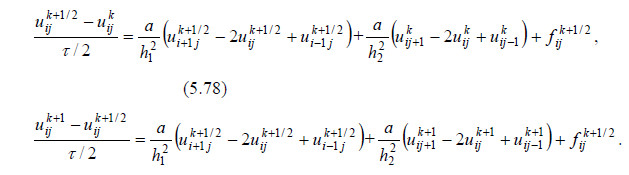

## Реализация

In [3]:
# метод прогонки
def tridig_matrix_alg(A, b):
    
    X = [0 for i in range(len(A[0]))]
    P = [0 for i in range(len(A[0]))]
    Q = [0 for i in range(len(A[0]))]
    P[0] = -A[0][1] / A[0][0]
    Q[0] = b[0] / A[0][0]
    
    for i in range(1, len(b)):
        if i != len(A[0]) - 1:
            P[i] = -A[i][i + 1] / (A[i][i] + P[i - 1] * A[i][i - 1])
        else:
            P[i] = 0
        Q[i] = (b[i] - Q[i - 1] * A[i][i - 1]) / (A[i][i] + P[i - 1] * A[i][i - 1])
    for i in range(len(b) - 1, -1, -1):
        if i != len(A[0]) - 1:
            X[i] = X[i + 1] * P[i] + Q[i]
        else:
            X[i] = Q[i]
    return X

In [4]:
def alternating_direction_method(T, Nx, Ny, K, m1, m2, lx=0, rx=np.pi, ly=0, ry=np.pi):
    tau = T / K
    hx = (rx - lx) / Nx
    hy = (ry - ly) / Ny
    x = [lx + i * hx for i in range(Nx + 1)]
    y = [ly + j * hy for j in range(Ny + 1)]
    t = [k * tau / 2 for k in range(2 * K + 1)]
    u = []
    row_x = []
    for i in range(Nx + 1):
        row_y = []
        for j in range(Ny + 1):
            row_y.append(uij0(m1, m2, x, y, i, j))
        row_x.append(row_y)
    u.append(row_x)
    u = np.array(u)
    ax = a / hx ** 2
    ay = a / hy ** 2
    
    for k in range(0, 2 * K + 1 - 2, 2):
        u = np.append(u, [[[0] * (Ny + 1)] * (Nx + 1)], axis=0)
        for j in range(Ny + 1):
            u[k + 1][0][j] = u0jk(m1, m2, y, t, j, k + 1)
            u[k + 1][Nx][j] = uNxjk(m1, m2, y, t, j, k + 1)
        for i in range(Nx + 1):
            u[k + 1][i][0] =  ui0k(m1, m2, x, t, i, k + 1)
            u[k + 1][i][Ny] = uiNyk(m1, m2, x, t, i, k + 1)
            
        for j in range(1, Ny):
            Ax = []
            bx = []
            for i in range(1, Nx):
                rows = []
                if i == 1:
                    bx.append(- (ay * u[k][i][j - 1] + 2 * (1 / tau - ay) * u[k][i][j] +\
                                 ay * u[k][i][j + 1] + ax * u[k + 1][i - 1][j])) #
                    rows = [ - 2 * (ax + 1 / tau) if (p == 1) else 0 for p in range(1, Nx)] #  
                    rows[1] = ax
                    Ax.append(rows)
                    continue
                elif i == Nx - 1:
                    bx.append(- (ay * u[k][i][j - 1] + 2 * (1 / tau - ay) * u[k][i][j] +\
                                 ay * u[k][i][j + 1] + ax * u[k + 1][i + 1][j])) #
                    rows = [ - 2 * (ax + 1 / tau) if (p == Nx - 1) else 0 for p in range(1, Nx)]# 
                    rows[Nx - 3] = ax
                    Ax.append(rows)
                    continue
                else:
                    bx.append( - (ay * u[k][i][j - 1] + 2 * (1/tau - ay) * u[k][i][j] +\
                                  ay *  u[k][i][j+1])) #
                for l in range(1, Nx):
                    if (l == i - 1) | (l == i + 1):
                        rows.append(ax)
                    elif l == i:
                        rows.append(- 2 * (ax + 1 / tau))
                    else:
                        rows.append(0)
                Ax.append(rows)
            res = tridig_matrix_alg(Ax, bx)
                                                             
            for i in range (1, Nx):
                u[k + 1][i][j] = res[i - 1]
                                                             
        u = np.append(u, [[[0] * (Ny + 1)] * (Nx + 1)], axis=0)
        for j in range(Ny + 1):
            u[k + 2][0][j] = u0jk(m1, m2, y, t, j, k + 2)
            u[k + 2][Nx][j] = uNxjk(m1, m2, y, t, j, k + 2)
        for i in range(Nx + 1):
            u[k + 2][i][0] = ui0k(m1, m2, x, t, i, k + 2)
            u[k + 2][i][Ny] = uiNyk(m1, m2, x, t, i, k + 2)
                                                             
        for i in range(1, Nx):
            Ay = []
            by = []
            for j in range(1, Ny):
                rows = []
                if j == 1:
                    by.append( - (ax * u[k + 1][i - 1][j] + 2*(1/tau - ax) * u[k + 1][i][j] +\
                              ax * u[k + 1][i+1][j] + ay * u[k+2][i][j-1])) # 
                    rows = [ - 2 * (ay + 1 / tau) if (p == 1) else 0 for p in range(1, Ny)]# 
                    rows[1] = ay
                    Ay.append(rows)
                    continue
                elif j == Ny - 1:
                    by.append( - (ax * u[k + 1][i - 1][j] + 2*(1/tau - ax) * u[k + 1][i][j] +\
                                  ax * u[k + 1][i+1][j] + ay * u[k+2][i][j+1]))  #
                    rows = [ - 2 * (ay + 1 / tau) if (p == Ny -1) else 0 for p in range(1, Ny)]  # 
                    rows[Ny - 3] = ay
                    Ay.append(rows)
                    continue
                else:
                    by.append( - (ax * u[k + 1][i - 1][j] + 2*(1/tau - ax) * u[k + 1][i][j] +\
                                  ax * u[k + 1][i+1][j] ))   # правка 3
                for l in range(1, Ny):
                    if (l == j - 1) | (l == j + 1):
                        rows.append(ay)
                    elif l == j:
                        rows.append(- 2 * (ay + 1 / tau))
                    else:
                        rows.append(0)
                Ay.append(rows)
            res = tridig_matrix_alg(Ay, by)
            for j in range (1, Ny):
                u[k + 2][i][j] = res[j - 1]
    return x, y, t, u

## Тест

In [5]:
def clean_u_t(u, t):
    new_u = np.array([u[k] for k in range(0, len(u), 2)])
    new_t = np.array([t[k] for k in range(0, len(t), 2)])
    return new_t, new_u

In [6]:
m1 = 1
m2 = 1
x, y, t, u = alternating_direction_method(3, 10, 10, 3, m1, m2)

In [7]:
t, u = clean_u_t(u, t)

## Графики решения

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [9]:
def calc_U_2d(U, t, m1, m2, lx, rx, ly, ry, dx, dy):
        xs = np.arange(lx, rx * m1 + dx, dx)
        ys = np.arange(ly, ry * m2 + dy, dy)
        U_ = []

        for x_ in xs:
            row = []
            for y_ in ys:
                row.append(U(x_, y_, t, m1, m2))
            U_.append(row)
        return xs, ys, U_
    

In [10]:
  def calc_Us_2d(k, u):
        return u[k]

In [11]:
def plot_solution(x, y, t, m1, m2, u, U, lx, rx, ly, ry):
        fig, axes = plt.subplots(2, 2)
        fig.set_figheight(10)
        fig.set_figwidth(15)
    
        dx = (rx * m1 - lx) / 1000
        dy = (ry * m2 - ly) / 1000
        dt = len(t) // 4
        for k in range(4):
            ulist = calc_Us_2d(k * dt, u) 
            xarr, yarr, Ulist = calc_U_2d(U, k * dt, m1, m2, lx, rx, ly, ry, dx, dy)
            ax = fig.add_subplot(2, 2, k + 1, projection='3d')
            ax.plot_surface(np.array(xarr), np.array(yarr), np.array(Ulist))
            ax.plot_wireframe(x, y, ulist, color="black")
            ax.set(xlabel='$x$', ylabel='$y$', zlabel='$U$')
            fig.tight_layout()

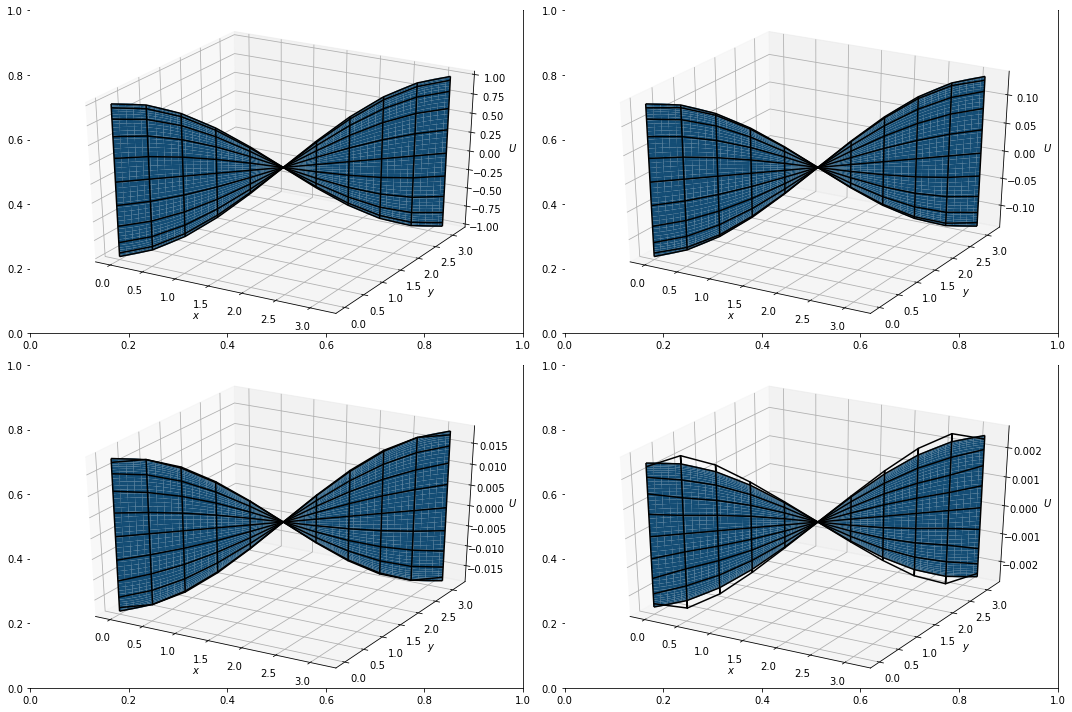

In [12]:
plot_solution(x, y, t, m1, m2, u, U, 0, np.pi,0, np.pi)

## Оценка погрешности

### MSE

In [13]:
def MSE(x, y, t, u, U, m1, m2):
    s = 0
    for k, t_ in enumerate(t):
        for i, x_ in enumerate(x):
            for j, y_ in enumerate(y):
                s += (U(x_, y_, t_, m1, m2) - u[k][i][j]) ** 2
    return np.sqrt(s)

In [14]:
print("MSE = {}".format(MSE(x, y, t, u, U, m1, m2)))

MSE = 0.010349404217681588


### Графики погрешности

In [15]:
# ошибки по x
def errors_x(x, y, t, u, U, m1, m2):
    errors= []
    for i, x_ in enumerate(x):
        err = 0
        for k, t_ in enumerate(t):
            for j, y_ in enumerate(y):
                err += (U(x_, y_, t_, m1, m2) - u[k][i][j]) ** 2
        errors.append(err ** 0.5)
    return errors

# ошибки по y
def errors_y(x, y, t, u, U, m1, m2):
    errors= []
    for j, y_ in enumerate(x):
        err = 0
        for k, t_ in enumerate(t):
            for i, x_ in enumerate(y):
                err += (U(x_, y_, t_, m1, m2) - u[k][i][j]) ** 2
        errors.append(err ** 0.5)
    return errors

# ошибки по t
def errors_t(x, y, t, u, U, m1, m2):
    errors= []
    for k, t_ in enumerate(t):
        err = 0
        for i, x_ in enumerate(x):
            for j, y_ in enumerate(y):
                err += (U(x_, y_, t_, m1, m2) - u[k][i][j]) ** 2
        errors.append(err ** 0.5)
    return errors

# функция отрисовки графиков ошибки по x
def plot_errors_x(x, y, t, u, U, m1, m2):
    plt.figure(figsize=(14,7))
    # погрешность по x
    plt.plot(x, errors_x(x, y, t, u, U, m1, m2), color = 'black')
    # отрисовка координатной сетки
    plt.grid(color = 'blue', linestyle = '--')
    # легенда
    plt.xlabel('x')
    plt.ylabel('eps')
    plt.title(f'Погрешность по x')
    plt.show()
    
# функция отрисовки графиков ошибки по t
def plot_errors_t(x, y, t, u, U, m1, m2):
    plt.figure(figsize=(14,7))
   # погрешность по t
    plt.plot(t, errors_t(x, y, t, u, U, m1, m2), color = 'black')
    # отрисовка координатной сетки
    plt.grid(color = 'blue', linestyle = '--')
    # легенда
    plt.xlabel('t')
    plt.ylabel('eps')
    plt.title(f'Погрешность по t')
    plt.show()
    
# функция отрисовки графиков ошибки по t
def plot_errors_y(x, y, t, u, U, m1, m2):
    plt.figure(figsize=(14,7))
   # погрешность по t
    plt.plot(y, errors_y(x, y, t, u, U, m1, m2), color = 'black')
    # отрисовка координатной сетки
    plt.grid(color = 'blue', linestyle = '--')
    # легенда
    plt.xlabel('t')
    plt.ylabel('eps')
    plt.title(f'Погрешность по y')
    plt.show()

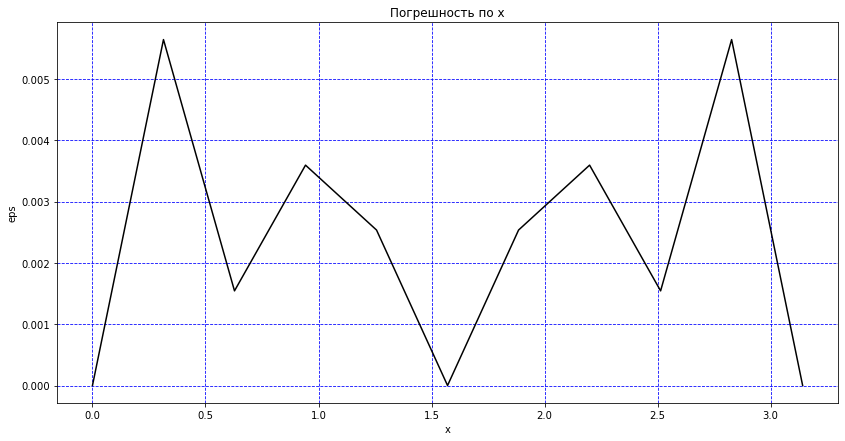

In [16]:
plot_errors_x(x, y, t, u, U, m1, m2)

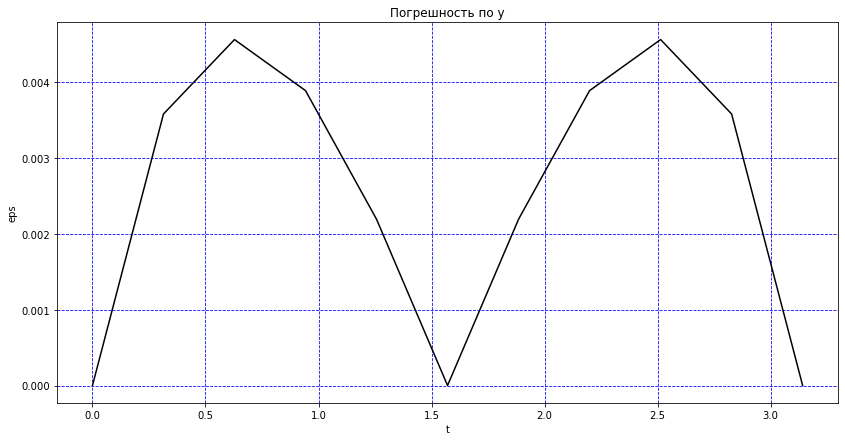

In [17]:
plot_errors_y(x, y, t, u, U, m1, m2)

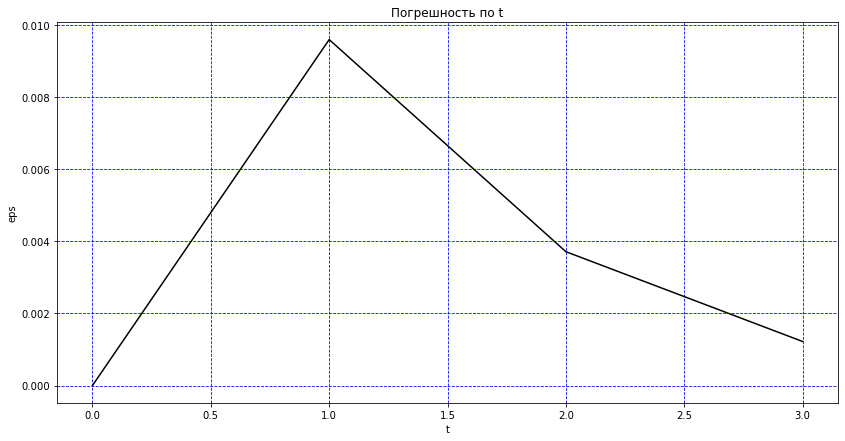

In [18]:
plot_errors_t(x, y, t, u, U, m1, m2)

# Метод дробных шагов

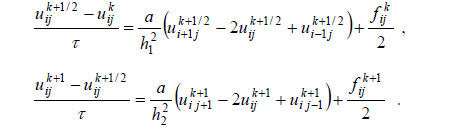

## Реализация

In [19]:
def fractional_step_method(T, Nx, Ny, K, m1, m2, lx=0, rx=np.pi, ly=0, ry=np.pi):
    rx = rx * m1
    ry = ry * m2
    tau = T / K
    hx = (rx - lx) / Nx
    hy = (ry - ly) / Ny
    x = [lx + i * hx for i in range(Nx + 1)]
    y = [ly + j * hy for j in range(Ny + 1)]
    t = [k * tau / 2 for k in range(2 * K + 1)]
    u = []
    
    row_x = []
    for i in range(Nx + 1):
        row_y = []
        for j in range(Ny + 1):
            row_y.append(uij0(m1, m2, x, y, i, j))
        row_x.append(row_y)
    u.append(row_x)
    
    u = np.array(u)
    ax = a / hx ** 2
    ay = a / hy ** 2
    
    for k in range(0, 2 * K + 1 - 2, 2):
        u = np.append(u, [[[0] * (Ny + 1)] * (Nx + 1)], axis=0)
        
        for j in range(Ny + 1):
            u[k + 1][0][j] = u0jk(m1, m2, y, t, j, k + 1)
            u[k + 1][Nx][j] = uNxjk(m1, m2, y, t, j, k + 1)
        for i in range(Nx + 1):
            u[k + 1][i][0] =  ui0k(m1, m2, x, t, i, k + 1)
            u[k + 1][i][Ny] = uiNyk(m1, m2, x, t, i, k + 1)
        for j in range(1, Ny):
            Ax = []
            bx = []
            for i in range(1, Nx):
                rows = []
                if i == 1:
                    bx.append( - (u[k][i][j] / tau + ax * u[k +1][i-1][j])) #
                    rows = [ - (2 * ax + 1 / tau) if (p == 1) else 0 for p in range(1, Ny)]#
                    rows[1] = ax
                    Ax.append(rows)
                    continue
                elif i == Nx - 1:
                    bx.append( -(u[k][i][j] / tau + ax * u[k +1][i+1][j])) #
                    rows = [ - (2 * ax + 1 / tau) if (p == Nx -1) else 0 for p in range(1, Ny)] #
                    rows[Nx - 3] = ax
                    Ax.append(rows)
                    continue
                else:
                    bx.append( - u[k][i][j] / tau)
                for l in range(1, Nx):
                    if (l == i - 1) | (l == i + 1):
                        rows.append(ax)
                    elif l == i:
                        rows.append(- (2 * ax + 1 / tau))
                    else:
                        rows.append(0)
                Ax.append(rows)
            res = tridig_matrix_alg(Ax, bx)
            for i in range (1, Nx):
                u[k + 1][i][j] = res[i - 1]
                
                                                      
        u = np.append(u, [[[0] * (Ny + 1)] * (Nx + 1)], axis=0)
        for j in range(Ny + 1):
            u[k + 2][0][j] = u0jk(m1, m2, y, t, j, k + 2)
            u[k + 2][Nx][j] = uNxjk(m1, m2, y, t, j, k + 2)
        for i in range(Nx + 1):
            u[k + 2][i][0] = ui0k(m1, m2, x, t, i, k + 2)
            u[k + 2][i][Ny] = uiNyk(m1, m2, x, t, i, k + 2)
        for i in range(1, Nx):
            Ay = []
            by = []
            for j in range(1, Ny):
                rows = []
                if j == 1:
                    by.append( - (u[k + 1][i][j] / tau + ay * u[k+2][i][j-1])) #
                    rows = [ - (2 * ay + 1 / tau) if (p == 1) else 0 for p in range(1, Ny)] #
                    rows[1] = ay
                    Ay.append(rows)
                    continue
                elif j == Ny - 1:
                    by.append( - (u[k + 1][i][j] / tau  + ay * u[k+2][i][j+1]))#
                    rows = [ - (2 * ay + 1 / tau) if (p == Ny - 1)else 0 for p in range(1, Ny)]#
                    rows[Ny - 3] = ay
                    Ay.append(rows)
                    continue
                else:
                    by.append( - u[k + 1][i][j] / tau)
                for l in range(1, Ny):
                    if (l == j - 1) | (l == j + 1):
                        rows.append(ay)
                    elif l == j:
                        rows.append(- (2 * ay + 1 / tau))
                    else:
                        rows.append(0)
                Ay.append(rows)
            res = tridig_matrix_alg(Ay, by)
            for j in range (1, Ny):
                u[k + 2][i][j] = res[j - 1]
    return x, y, t, u

## Тест

In [20]:
m1 = 1
m2 = 1
x, y, t, u = fractional_step_method(3, 10, 10, 3, m1, m2)

In [21]:
t, u = clean_u_t(u, t)

## Графики решения

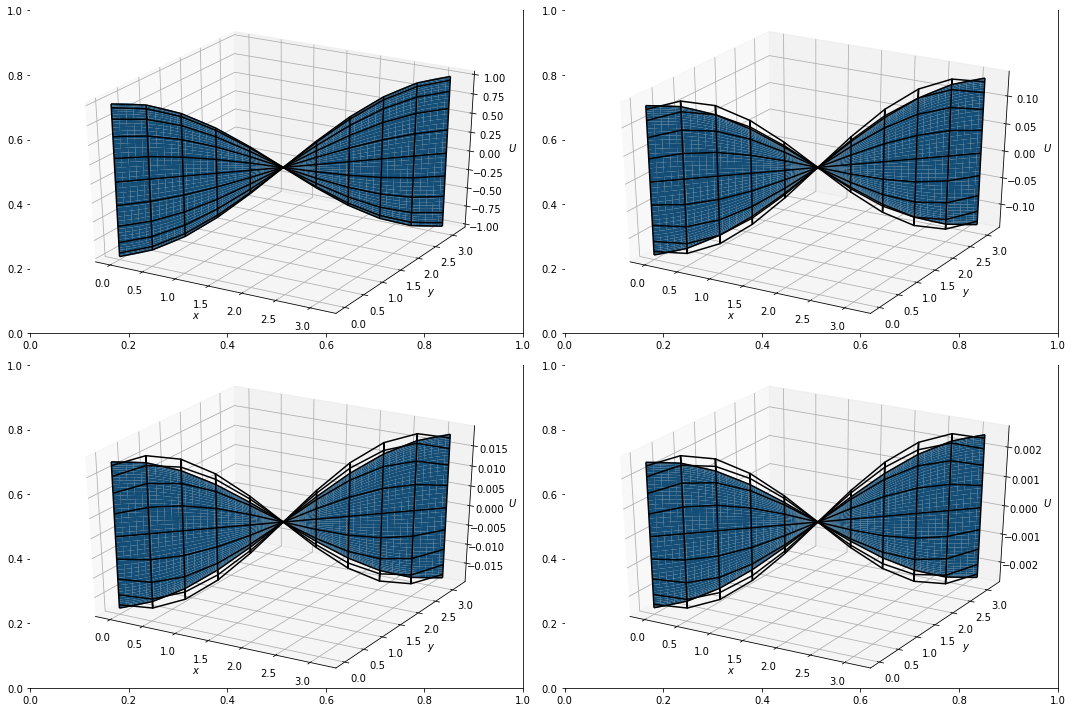

In [22]:
plot_solution(x, y, t, m1, m2, u, U, 0, np.pi,0, np.pi)

## Оценка погрешности

### MSE

In [23]:
print("MSE = {}".format(MSE(x, y, t, u, U, m1, m2)))

MSE = 0.11522428415985596


### Графики погрешности

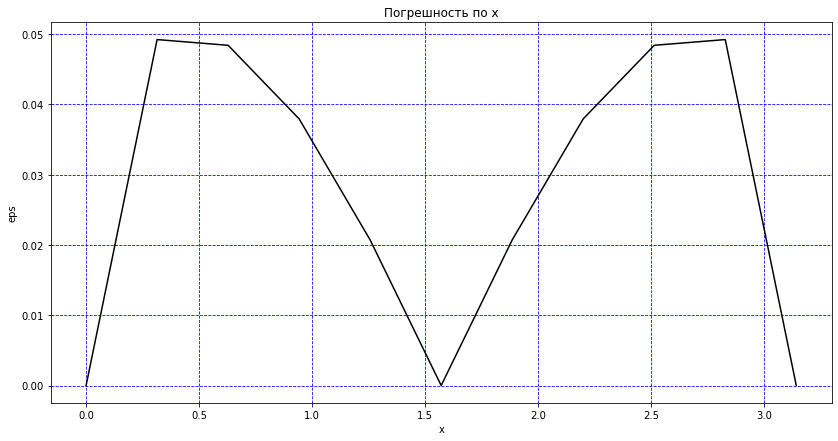

In [24]:
plot_errors_x(x, y, t, u, U, m1, m2)

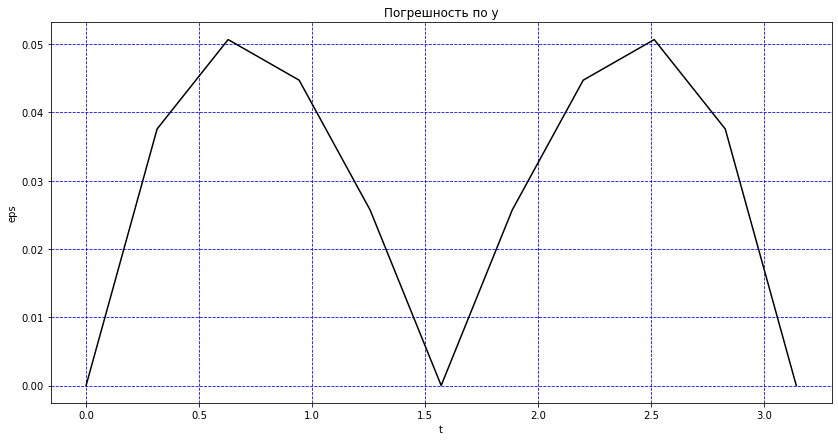

In [25]:
plot_errors_y(x, y, t, u, U, m1, m2)

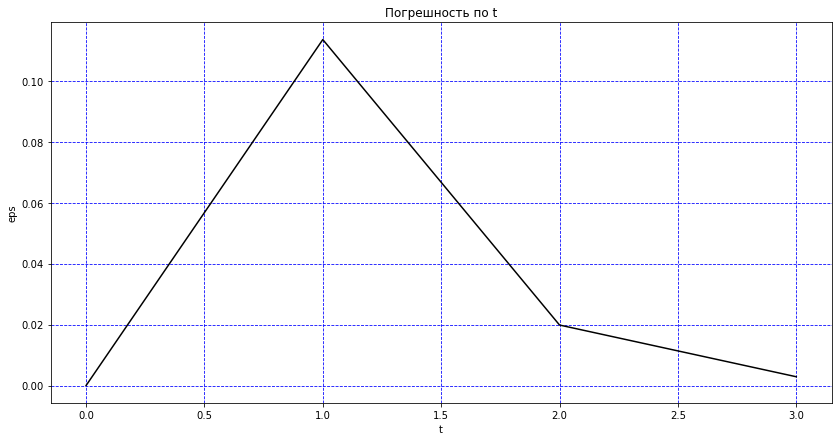

In [26]:
plot_errors_t(x, y, t, u, U, m1, m2)

# Вывод

В резлуьтате выполнения лабораторной работы были освоены две схемы для решения двумерной начально-краевой задачи для дифференциального уравнения параболического типа : метод переменных направлений и метод дробныйх шагов.

Метод переменных направлений показал лучший резлуьтат, чем метод дробных шагов, это можно заметить как по графикам решения, так и по графикам погрешности и величине средне-квадратичной ошибки. Стоит отметить, что метод переменных направлений условно устойчив при увелечении размерности пространства, а метод дробных шагов абсолютно устойчив.